# Autoencoder

## Preparations
### Load libraries

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers

In [3]:
import pickle

In [4]:
tf.random.set_seed(123)
np.random.seed(123)

### Prepare data

In [5]:
# Load data:
mnist = tf.keras.datasets.mnist
(train_val_images, train_val_labels), (test_images, test_labels) = mnist.load_data()

# Scale image data:
train_val_images = train_val_images / 255.0
test_images = test_images / 255.0

# Split into training / validation
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels,
                                                                      test_size=0.20, random_state=42)

In [6]:
train_val_label_df = pd.DataFrame(train_val_labels)
train_val_label_df.columns = ['label']
train_val_label_df['label'].value_counts()

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

In [7]:
val_label_df = pd.DataFrame(val_labels)
val_label_df.columns = ['label']
val_label_df['label'].value_counts(sort=False, ascending=True)

label
7    1299
3    1219
8    1160
9    1194
5    1104
4    1176
2    1174
6    1177
1    1322
0    1175
Name: count, dtype: int64

In [8]:
train_from_scratch = True

## The Autoencoder
Every autoencoder consists of two parts: an encoder and a decoder.

* The **encoder** receives the original data (in our case, the black and white images) as input and generates a lower-dimensional code from it.
* The **decoder** receives the code and decodes it into original data (e.g. the images) in the same format as the encoder's inputs.

### Model definition

The two parts put together form the autoencoder:

**Comments on activation functions:**

***Why ReLU?***

* Simplicity and Efficiency: ReLU (Rectified Linear Unit) is computationally efficient because it involves simple thresholding at zero. This makes it faster to compute compared to other activation functions.
* Sparse Activation: ReLU promotes sparsity in the network by setting negative values to zero, which can help in learning more robust features.
* Gradient Propagation: ReLU helps mitigate the vanishing gradient problem, allowing gradients to propagate more effectively during backpropagation.

***Why Not SELU?***

SELU (Scaled Exponential Linear Unit) is another excellent activation function, especially for self-normalizing neural networks. However, SELU requires careful initialization and specific network architecture (e.g., no Batch Normalization) to maintain its self-normalizing properties. For a straightforward convolutional autoencoder, ReLU is often preferred due to its simplicity and effectiveness.

***Sigmoid*** at the end to get an output between 0 and 1.

In [9]:
mnist_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu')
])

mnist_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (100,)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae = tf.keras.Sequential([mnist_encoder, mnist_decoder])

### Training
The autoencoder uses unsupervised learning, i.e. we do not pass any predefined labels or similar. Instead, the output should be as similar as possible to the input. We use the squared error as a measure of the quality of the reconstruction.

For a start, we allow a maximum of 10 epochs to train - as with the other convolutional networks (and with deep neural networks in general), you should allow significantly more epochs for real applications.

In [10]:
# compile and fit the model
tf.random.set_seed(42) 
mnist_ae.compile(loss="mse", optimizer="nadam")

In [11]:
mnist_ae.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 100)            │       265,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │       266,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,884 (2.03 MB)

 Trainable params: 531,884 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

The training takes a little longer here... With the following code you can save and reload the learned weights - just set `train_from_scratch` as needed.
Please note that only the weights, not the models themselves, are saved and loaded again. The model definition is made in the code and managed as such.

Loading the weights only works if the model definition is exactly the same.

In [12]:
nEpochs = 100
nPatience = 10

# define paths:
encoder_weights_path = './pretrained/mnist_encoder.weights.h5'
decoder_weights_path = './pretrained/mnist_decoder.weights.h5'
history_path = './pretrained/mnist_ae.history.h5'


train_from_scratch = True
if train_from_scratch:
    history_ae = mnist_ae.fit(train_images, train_images, epochs=nEpochs, validation_data=(val_images, val_images),
                       callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience, 
                                                   verbose=False, restore_best_weights=True)])
    
    # Save the weights:
    mnist_encoder.save_weights(encoder_weights_path)
    mnist_decoder.save_weights(decoder_weights_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_ae, f)

else:
    # load previsously computed weights
    fashion_encoder.load_weights(encoder_weights_path)
    fashion_decoder.load_weights(decoder_weights_path)

    # load history:
    with open(history_path, 'rb') as f:
        history_ae = pickle.load(f)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0324 - val_loss: 0.0071
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 11/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 12/100
1500/1

### Looking at the reconstructions
Let's look at some of the reconstructed images:

In [16]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=test_images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


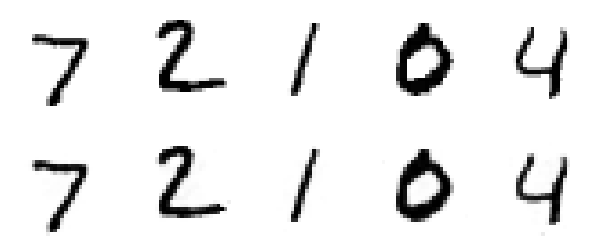

In [17]:
show_reconstructions(mnist_ae)

In [18]:
def plot_history(history):
    """
    Plot model training history.
    Args:
    - history: tensorflow history object.

    Returns:
    None
    """
    plt.plot(history['loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.legend()
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

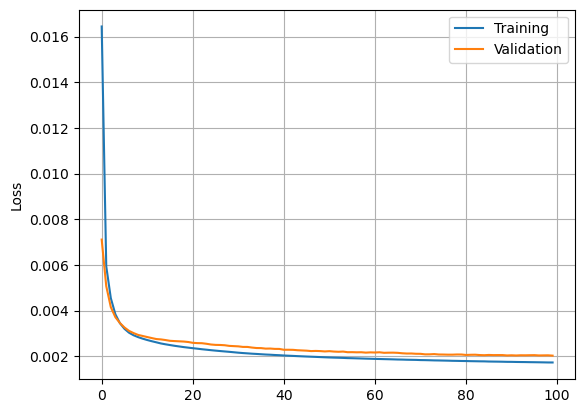

In [20]:
plot_history(history_ae.history)

## Sparse Autoencoders

### Encoding Dimension 30

In [24]:
mnist_encoder_sparse30 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

mnist_decoder_sparse30 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (30,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae_sparse30 = tf.keras.Sequential([mnist_encoder_sparse30, mnist_decoder_sparse30])
mnist_ae_sparse30.compile(loss="mse", optimizer="nadam")

In [25]:
mnist_encoder_sparse30.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,630 (1.02 MB)

 Trainable params: 268,630 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# define paths:
mnist_encoder_sparse30_path = './pretrainedWeights/mnist_encoder_sparse30.weights.h5'
mnist_decoder_sparse30_path = './pretrainedWeights/mnist_decoder_sparse30.weights.h5'
history_path = './pretrained/mnist_decoder_sparse30.history.h5'

if train_from_scratch:
    history30 = mnist_ae_sparse30.fit(train_images, train_images, epochs=50, validation_data=(val_images, val_images),
                                    callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                verbose=False, restore_best_weights=True)])
    
    # Save the weights:
    mnist_encoder_sparse30.save_weights(mnist_encoder_sparse30_path)
    mnist_decoder_sparse30.save_weights(mnist_decoder_sparse30_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history30, f)

else:
    # load previsously computed weights
    mnist_encoder_sparse30.load_weights(mnist_encoder_sparse30_path)
    mnist_decoder_sparse30.load_weights(mnist_decoder_sparse30_path)

    # load history:
    with open(history_path, 'rb') as f:
        history30 = pickle.load(f)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0416 - val_loss: 0.0145
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0133 - val_loss: 0.0113
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0107 - val_loss: 0.0100
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0077 - val_loss: 0.0081
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 12/50
1500/1500 ━━━━━━━━

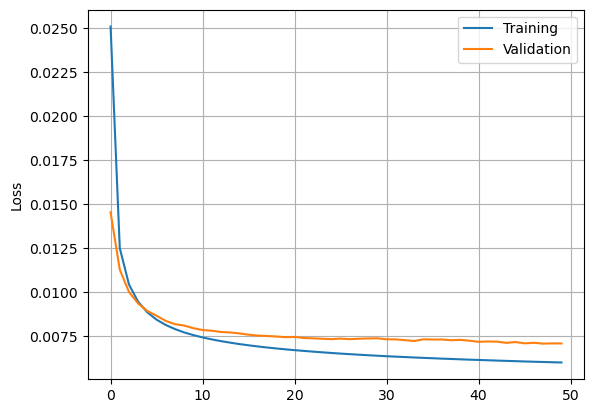

In [27]:
plot_history(history30.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


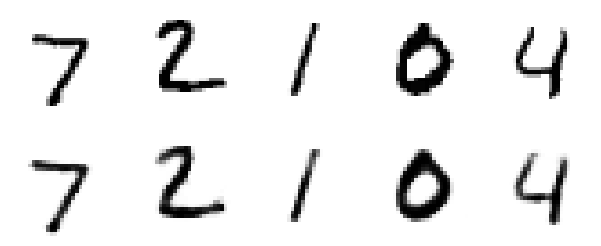

In [28]:
show_reconstructions(mnist_ae_sparse30)

### Encoding Dimension 5

In [31]:
mnist_encoder_sparse5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu')
])

mnist_decoder_sparse5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (5,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae_sparse5 = tf.keras.Sequential([mnist_encoder_sparse5, mnist_decoder_sparse5])
mnist_ae_sparse5.compile(loss="mse", optimizer="nadam")

In [32]:
# define paths:
mnist_encoder_sparse5_path = './pretrainedWeights/mnist_encoder_sparse5.weights.h5'
mnist_decoder_sparse5_path = './pretrainedWeights/mnist_decoder_sparse5.weights.h5'
history_path = './pretrained/mnist_decoder_sparse5.history.h5'

if train_from_scratch:
    history5 = mnist_ae_sparse5.fit(train_images, train_images, epochs=50, validation_data=(val_images, val_images),
                                    callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                verbose=False, restore_best_weights=True)])
    
    # Save the weights:
    mnist_encoder_sparse5.save_weights(mnist_encoder_sparse5_path)
    mnist_decoder_sparse5.save_weights(mnist_decoder_sparse5_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history5, f)

else:
    # load previsously computed weights
    mnist_encoder_sparse5.load_weights(mnist_encoder_sparse5_path)
    mnist_decoder_sparse5.load_weights(mnist_decoder_sparse5_path)

    # load history:
    with open(history_path, 'rb') as f:
        history5 = pickle.load(f)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0585 - val_loss: 0.0347
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0338 - val_loss: 0.0318
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0312 - val_loss: 0.0300
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0295 - val_loss: 0.0289
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0284 - val_loss: 0.0285
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0277 - val_loss: 0.0279
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0272 - val_loss: 0.0275
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0267 - val_loss: 0.0271
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0263 - val_loss: 0.0270
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0260 - val_loss: 0.0267
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0258 - val_loss: 0.0266
Epoch 12/50
1500/1500 ━━━━━━━━

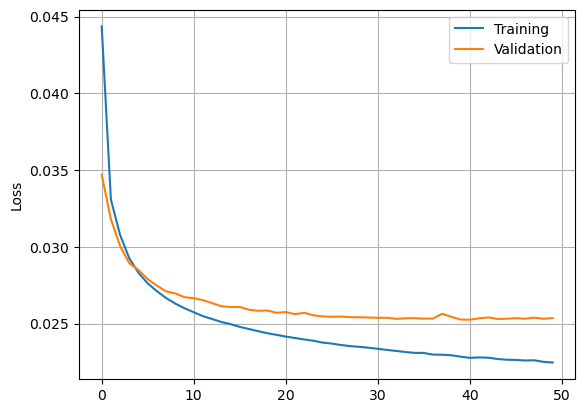

In [34]:
plot_history(history5.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


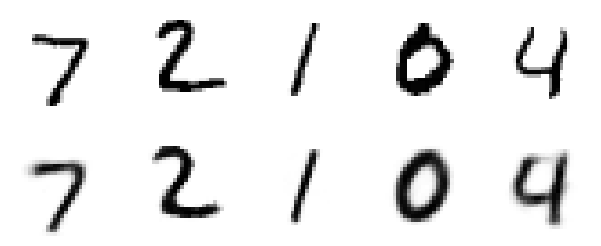

In [35]:
show_reconstructions(mnist_ae_sparse5)

### Encoding Dimension 2

In [40]:
mnist_encoder_sparse2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu')
])

mnist_decoder_sparse2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (2,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae_sparse2 = tf.keras.Sequential([mnist_encoder_sparse2, mnist_decoder_sparse2])
mnist_ae_sparse2.compile(loss="mse", optimizer="nadam")

In [41]:
# define paths:
mnist_encoder_sparse2_path = './pretrainedWeights/mnist_encoder_sparse2.weights.h5'
mnist_decoder_sparse2_path = './pretrainedWeights/mnist_decoder_sparse2.weights.h5'
history_path = './pretrained/mnist_decoder_sparse2.history.h5'

if train_from_scratch:
    history2 = mnist_ae_sparse2.fit(train_images, train_images, epochs=50, validation_data=(val_images, val_images),
                                    callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                verbose=False, restore_best_weights=True)])
    
    # Save the weights:
    mnist_encoder_sparse2.save_weights(mnist_encoder_sparse2_path)
    mnist_decoder_sparse2.save_weights(mnist_decoder_sparse2_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history2, f)

else:
    # load previsously computed weights
    mnist_encoder_sparse2.load_weights(mnist_encoder_sparse2_path)
    mnist_decoder_sparse2.load_weights(mnist_decoder_sparse2_path)

    # load history:
    with open(history_path, 'rb') as f:
        history2 = pickle.load(f)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0693 - val_loss: 0.0562
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0551 - val_loss: 0.0497
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0477 - val_loss: 0.0444
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0440 - val_loss: 0.0428
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0428 - val_loss: 0.0415
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0415 - val_loss: 0.0407
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0407 - val_loss: 0.0401
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0404 - val_loss: 0.0399
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0398 - val_loss: 0.0395
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0393 - val_loss: 0.0397
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0395 - val_loss: 0.0388
Epoch 12/50
1500/1500 ━━━━━━━━

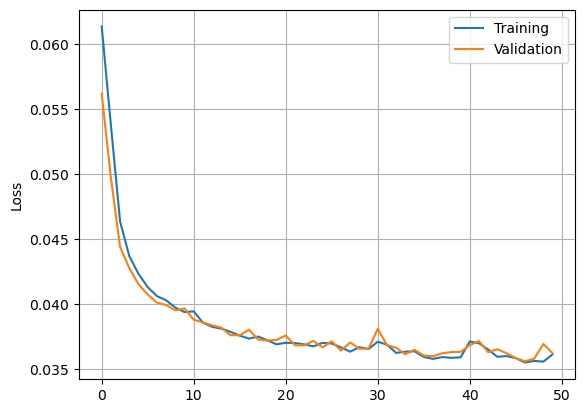

In [43]:
plot_history(history2.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


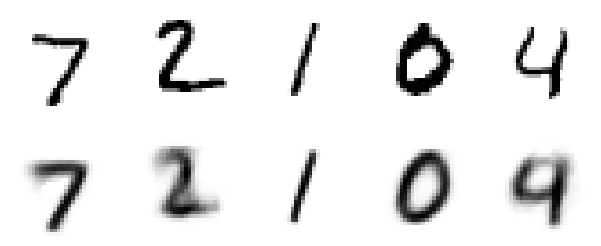

In [44]:
show_reconstructions(mnist_ae_sparse2)

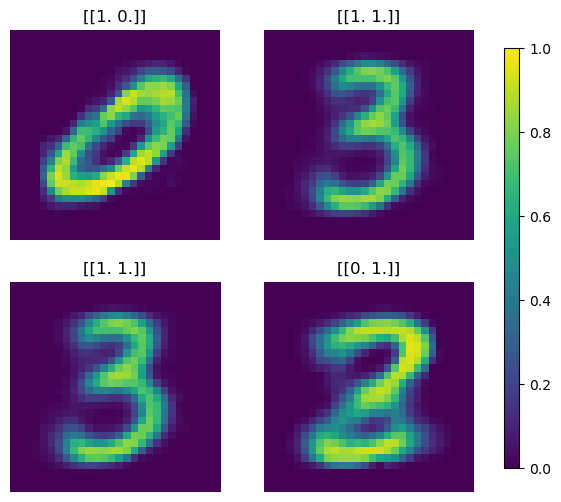

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for ID1 in range(2):
    for ID2 in range(2):
        code = np.zeros(shape=[1, 2])
        code[0, ID1] = 1
        code[0, ID2] = 1
        coding = np.squeeze(mnist_decoder_sparse2(code))
        im = axs[ID1, ID2].imshow(coding, vmin=0, vmax=1)
        axs[ID1, ID2].axis('off')
        axs[ID1, ID2].set_title(code)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

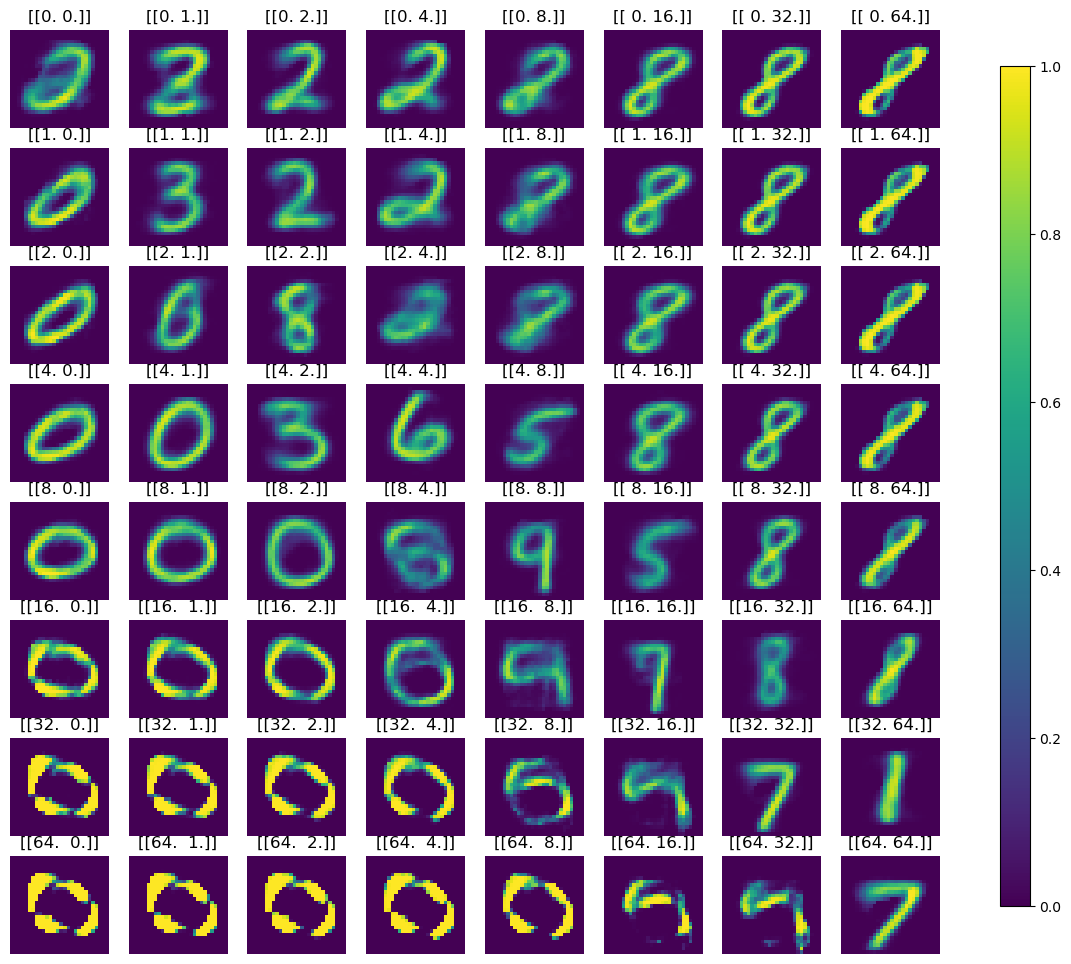

In [47]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))

for val1 in np.linspace(0, 7, 8):
    for val2 in np.linspace(0, 7, 8):
        code = np.zeros(shape=[1, 2])
        if val1>0:
            code[0, 0] = 2**(val1-1)
        if val2>0:
            code[0, 1] = 2**(val2-1)
        coding = np.squeeze(mnist_decoder_sparse2(code))
        im = axs[int(val1), int(val2)].imshow(coding, vmin=0, vmax=1)
        axs[int(val1), int(val2)].axis('off')
        axs[int(val1), int(val2)].set_title(code)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [48]:
val_encodings2 = mnist_encoder_sparse2(val_images)

In [49]:
val_encodings2.shape

TensorShape([12000, 2])

In [50]:
val_encodings2[:10,:]

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[56.030907  , 48.03546   ],
       [ 0.8791285 ,  0.9460507 ],
       [ 6.758935  , 24.90759   ],
       [12.878229  , 14.948537  ],
       [ 0.08987427,  0.5633851 ],
       [ 8.257215  ,  9.58755   ],
       [53.199623  , 49.089954  ],
       [46.067     , 42.189194  ],
       [ 2.6643088 ,  1.6040738 ],
       [ 6.5120277 ,  6.448985  ]], dtype=float32)>

In [51]:
sparseAE_embedding = pd.DataFrame(val_encodings2)
sparseAE_embedding.columns = ['Dimension 1', 'Dimension 2']
sparseAE_embedding['label'] = val_labels

In [52]:
sparseAE_embedding.shape

(12000, 3)

In [53]:
val_labels.shape

(12000,)

<Axes: xlabel='Dimension 1', ylabel='Dimension 2'>

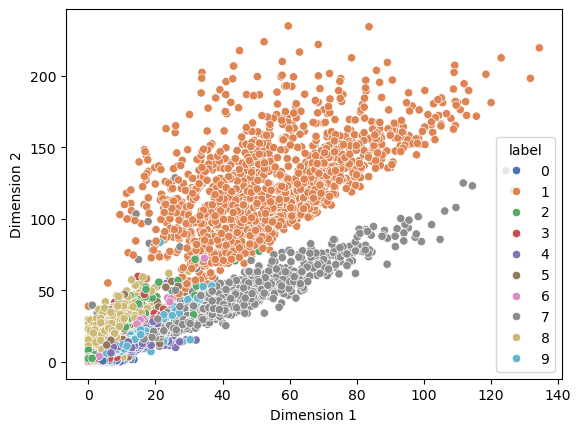

In [54]:
sns.scatterplot(sparseAE_embedding, x='Dimension 1', y='Dimension 2', hue='label', legend='full', palette='deep')

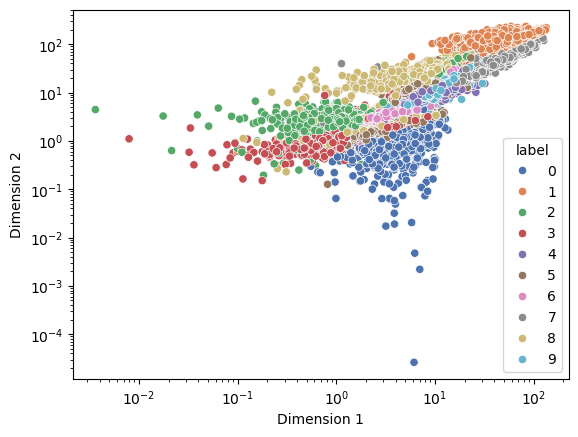

In [55]:
sns.scatterplot(sparseAE_embedding, x='Dimension 1', y='Dimension 2', hue='label', legend='full', palette='deep')
plt.xscale('log')
plt.yscale('log')

## Denoising Autoencoders

### Generate Noisy Data

In [57]:
def add_noise(image_array, noise_factor=0.4):
    """Adds random noise to each image in the supplied array."""
    noisy_array = (1-noise_factor) * image_array + noise_factor * np.random.random(size=image_array.shape)
    return noisy_array

In [58]:
from sklearn.decomposition import PCA

# Add noise:
# - to training images
train_images_noisy = add_noise(train_images)

# - to validation images
val_images_noisy = add_noise(val_images)

# - to test images
test_images_noisy = add_noise(test_images)

# flatten images:
train_images_noisy_flat = train_images_noisy.reshape(train_images_noisy.shape[0], -1)
val_images_noisy_flat = val_images_noisy.reshape(val_images_noisy.shape[0], -1)
test_images_noisy_flat = test_images_noisy.reshape(test_images_noisy.shape[0], -1)

PCA(n_components=32, random_state=42)

### Denoising with PCA

In [ ]:
# Apply PCA to reduce to 32 components
pca = PCA(n_components=32, random_state=42)
pca.fit(test_images_noisy_flat)

In [59]:
test_images_noisy.shape

(10000, 28, 28)

In [60]:
PCA(n_components=32, random_state=42)

PCA(n_components=32, random_state=42)

In [61]:
reconstructed_pca = pca.inverse_transform(pca.transform(test_images_noisy_flat))

In [62]:
import matplotlib.pyplot as plt

def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(8, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="binary")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

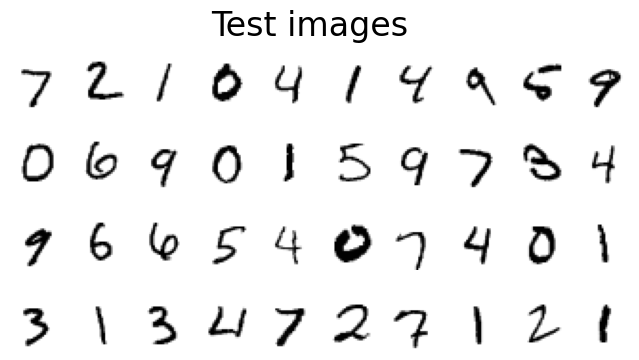

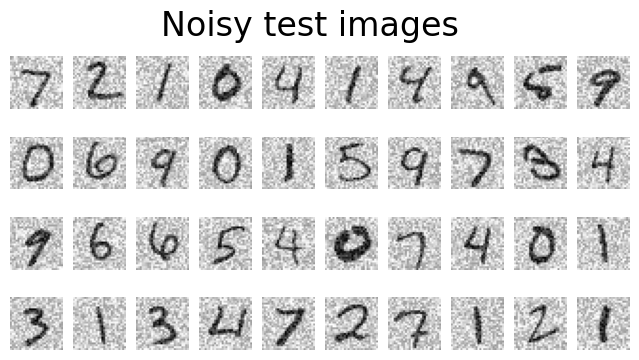

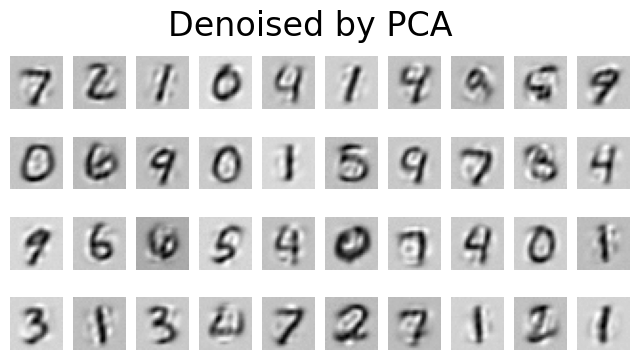

In [63]:
# Visualize the PCA results
plot_digits(test_images, "Test images")
plot_digits(test_images_noisy, "Noisy test images")
plot_digits(reconstructed_pca, "Denoised by PCA")

### Denoising with AE

In [64]:
mnist_encoder_denoise = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

mnist_decoder_denoise = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (30,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid'),
    tf.keras.layers.Reshape([28, 28, 1])
])

mnist_ae_denoise = tf.keras.Sequential([mnist_encoder_denoise, mnist_decoder_denoise])
mnist_ae_denoise.compile(loss="mse", optimizer="nadam")

In [65]:
# define paths:
mnist_encoder_denoise_path = './pretrainedWeights/mnist_encoder_denoise.weights.h5'
mnist_decoder_denoise_path = './pretrainedWeights/mnist_decoder_denoise.weights.h5'
history_path = './pretrained/mnist_decoder_denoise.history.h5'

if train_from_scratch:
    history_denoise  = mnist_ae_denoise.fit(train_images_noisy, train_images, epochs=50, validation_data=(val_images_noisy, val_images),
                                           callbacks = [ EarlyStopping(monitor='val_loss', patience=nPatience,
                                                                       verbose=False, restore_best_weights=True)])
                                       
    # Save the weights:
    mnist_encoder_denoise.save_weights(mnist_encoder_denoise_path)
    mnist_decoder_denoise.save_weights(mnist_decoder_denoise_path)

    # Save training history:
    with open(history_path, 'wb') as f:
        pickle.dump(history_denoise, f)

else:
    # load previsously computed weights
    mnist_encoder_denoise.load_weights(mnist_encoder_denoise_path)
    mnist_decoder_denoise.load_weights(mnist_decoder_denoise_path)

    # load history:
    with open(history_path, 'rb') as f:
        history_denoise = pickle.load(f)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0472 - val_loss: 0.0209
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0196 - val_loss: 0.0167
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0160 - val_loss: 0.0146
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0123 - val_loss: 0.0124
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0117 - val_loss: 0.0120
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0113 - val_loss: 0.0117
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0106 - val_loss: 0.0112
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0103 - val_loss: 0.0110
Epoch 12/50
1500/1500 ━━━━━━━━

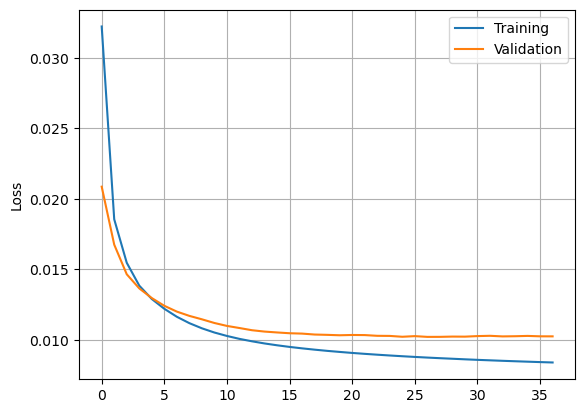

In [67]:
plot_history(history_denoise.history)

In [68]:
reconstructed_ae = mnist_ae_denoise(test_images_noisy)

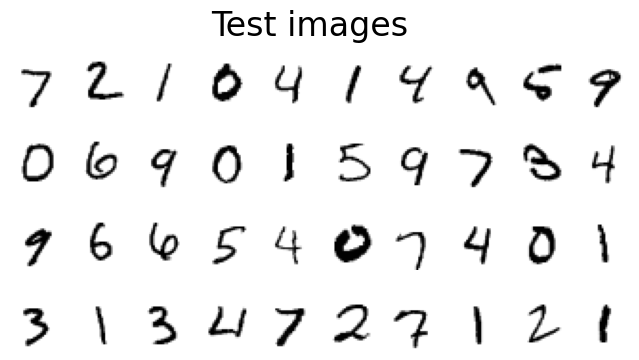

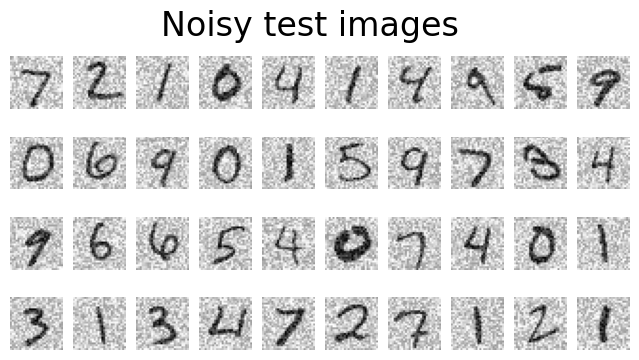

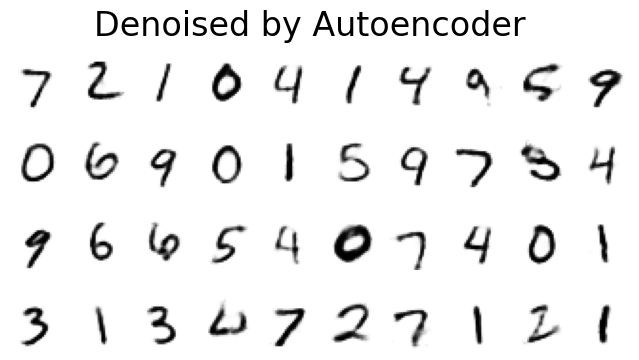

In [69]:
# Visualize the AE results
plot_digits(test_images, "Test images")
plot_digits(test_images_noisy, "Noisy test images")
plot_digits(reconstructed_ae.numpy(), "Denoised by Autoencoder")